# Purpose of the notebook
* recreate twitter sentimental analysis model
* use the model to scored medical related reddit comments

In [103]:
# !pip install gensim --upgrade
# !pip install keras --upgrade
# !pip install tensorflow --upgrade

In [2]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/richardwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# load in the tweeter sentimental data and retrain the model

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [5]:
# dataset_filename = os.listdir("../input")[0]
# dataset_path = os.path.join("..","input",dataset_filename)
# print("Open file:", dataset_path)
df = pd.read_csv('Project/new_data/kaggle/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [6]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [7]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 434 ms, sys: 8.25 ms, total: 442 ms
Wall time: 446 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

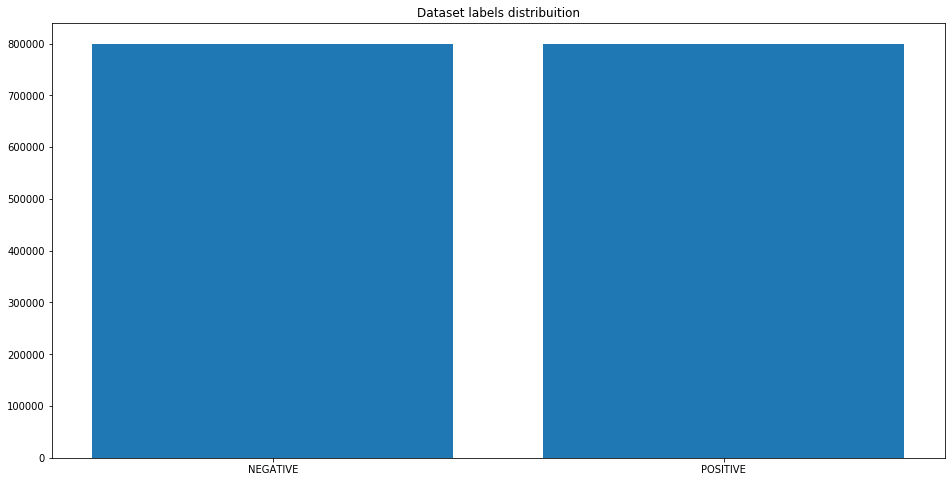

In [8]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [9]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [10]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [12]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 3.63 s, sys: 385 ms, total: 4.02 s
Wall time: 4.03 s


In [13]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [14]:
w2v_model.build_vocab(documents)

2020-11-18 16:19:59,031 : INFO : collecting all words and their counts
2020-11-18 16:19:59,032 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-11-18 16:19:59,063 : INFO : PROGRESS: at sentence #10000, processed 132112 words, keeping 29901 word types
2020-11-18 16:19:59,098 : INFO : PROGRESS: at sentence #20000, processed 263673 words, keeping 51026 word types
2020-11-18 16:19:59,139 : INFO : PROGRESS: at sentence #30000, processed 393870 words, keeping 69231 word types
2020-11-18 16:19:59,180 : INFO : PROGRESS: at sentence #40000, processed 526649 words, keeping 86122 word types
2020-11-18 16:19:59,225 : INFO : PROGRESS: at sentence #50000, processed 657596 words, keeping 102097 word types
2020-11-18 16:19:59,264 : INFO : PROGRESS: at sentence #60000, processed 788578 words, keeping 117455 word types
2020-11-18 16:19:59,300 : INFO : PROGRESS: at sentence #70000, processed 919604 words, keeping 131952 word types
2020-11-18 16:19:59,342 : INFO : PROGRESS: 

In [15]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 59839


In [16]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-11-18 16:20:33,002 : INFO : training model with 8 workers on 59839 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-11-18 16:20:34,027 : INFO : EPOCH 1 - PROGRESS: at 9.49% examples, 1158587 words/s, in_qsize 14, out_qsize 1
2020-11-18 16:20:35,047 : INFO : EPOCH 1 - PROGRESS: at 19.45% examples, 1183019 words/s, in_qsize 15, out_qsize 0
2020-11-18 16:20:36,049 : INFO : EPOCH 1 - PROGRESS: at 29.33% examples, 1196034 words/s, in_qsize 13, out_qsize 2
2020-11-18 16:20:37,057 : INFO : EPOCH 1 - PROGRESS: at 39.27% examples, 1202767 words/s, in_qsize 15, out_qsize 0
2020-11-18 16:20:38,064 : INFO : EPOCH 1 - PROGRESS: at 48.56% examples, 1190867 words/s, in_qsize 15, out_qsize 1
2020-11-18 16:20:39,076 : INFO : EPOCH 1 - PROGRESS: at 57.01% examples, 1165179 words/s, in_qsize 14, out_qsize 1
2020-11-18 16:20:40,083 : INFO : EPOCH 1 - PROGRESS: at 65.31% examples, 1144369 words/s, in_qsize 14, out_qsize 1
2020-11-18 16:20:41,085 : INFO : EPOCH 1 - PRO

CPU times: user 25min 19s, sys: 9.94 s, total: 25min 29s
Wall time: 5min 30s


(396115800, 539612384)

In [17]:
w2v_model.most_similar("love")

/Users/richardwang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-11-18 16:26:03,694 : INFO : precomputing L2-norms of word weight vectors


[('adore', 0.7259747982025146),
 ('LOVE', 0.6829929947853088),
 ('luv', 0.6729847192764282),
 ('loveee', 0.6664007902145386),
 ('loooove', 0.6617765426635742),
 ('looove', 0.6607675552368164),
 ('miss', 0.6160344481468201),
 ('lovee', 0.6156436800956726),
 ('loved', 0.6125247478485107),
 ('loove', 0.6046488285064697)]

In [18]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 594849
CPU times: user 20.9 s, sys: 188 ms, total: 21.1 s
Wall time: 21.2 s


In [19]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 28.4 s, sys: 925 ms, total: 29.4 s
Wall time: 29.6 s


In [20]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [22]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(594849, 300)


In [24]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          178454700 
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 178,615,201
Trainable params: 160,501
Non-trainable params: 178,454,700
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [27]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [28]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.7678WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-18 19:11:02,923 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 8142s 7s/step - loss: 0.4810 - accuracy: 0.7678 - val_loss: 0.4284 - val_accuracy: 0.8028
Epoch 2/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4428 - accuracy: 0.7920WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-18 20:30:11,117 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 4744s 4s/step - loss: 0.4428 - accuracy: 0.7920 - val_loss: 0.4120 - val_accuracy: 0.8124
Epoch 3/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.7987 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 12:54:06,573 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 59031s 52s/step - loss: 0.4317 - accuracy: 0.7987 - val_loss: 0.4062 - val_accuracy: 0.8168
Epoch 4/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.8025 WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 16:54:18,305 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 14408s 13s/step - loss: 0.4258 - accuracy: 0.8025 - val_loss: 0.4016 - val_accuracy: 0.8189
Epoch 5/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4219 - accuracy: 0.8046WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 17:57:09,616 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3768s 3s/step - loss: 0.4219 - accuracy: 0.8046 - val_loss: 0.3985 - val_accuracy: 0.8210
Epoch 6/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4193 - accuracy: 0.8061WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 19:57:46,189 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 7233s 6s/step - loss: 0.4193 - accuracy: 0.8061 - val_loss: 0.3986 - val_accuracy: 0.8220
Epoch 7/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8074WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 21:01:42,895 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3832s 3s/step - loss: 0.4170 - accuracy: 0.8074 - val_loss: 0.3952 - val_accuracy: 0.8228
Epoch 8/8
1125/1125 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8079WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


2020-11-19 22:05:23,814 : WARNING : Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


1125/1125 [==============================] - 3817s 3s/step - loss: 0.4157 - accuracy: 0.8079 - val_loss: 0.3938 - val_accuracy: 0.8236
CPU times: user 2d 9h 22min 18s, sys: 1d 7h 56min 25s, total: 3d 17h 18min 44s
Wall time: 1d 5h 10min 11s


In [73]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE


def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return  float(score)

In [76]:
predict("I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music, I love the music")

0.9979958534240723

# Read in the reddit comments data regarding medical terms
* twitter sentiment model will be used to scored the data

In [71]:
reddit_data = pd.read_csv('Project/google_cloud/bq-results-20201112-002933-ro03kqmma4h5.csv')

/Users/richardwang/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
reddit_data = reddit_data[['body']]

In [101]:
# reddit_data['sentiment'] = reddit_data.body.apply(predict)

In [134]:
start = time.time()


prediction = model.predict(pad_sequences(tokenizer.texts_to_sequences(reddit_data.body) , maxlen=SEQUENCE_LENGTH))
print('process took {:,.0f} sec'.format(time.time() - start))

process took 685 sec


In [143]:
reddit_data['sentiment'] = prediction

In [144]:
reddit_data

,body,sentiment
0,People who have been *legally* declared [menta...,0.605968
1,&gt; why only 17% of energy is nuclear\n\nand ...,0.699032
2,Fucking gabapentin. I went to pain management ...,0.061821
3,so that means SC men would just get it illegal...,0.785086
4,Tell her to take pills or morning after pills....,0.597251
...,...,...
402286,&gt; Google is not a technology company? Googl...,0.750558
402287,&gt; Albuterol is wildly safer and more effect...,0.485028
402288,Do you know what happens when you mix Alcohol ...,0.939480
402289,Arteezy also using performance enhancing drugs...,0.196580


In [174]:
reddit_data.to_csv('Project/google_cloud/reddit_with_sentiment.csv', sep=',', line_terminator='\r')

In [9]:
df_check = pd.read_csv('Project/google_cloud/reddit_with_sentiment.csv', sep=',', lineterminator='\r', index_col=0)